In [ ]:
%%writefile fr.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <limits.h>
#include <float.h>
#include <sys/time.h>
#include <cuda_runtime.h>
#include <ctype.h>

#define BLOCK_SIZE 16
#define HIST_SIZE 256

// Function to allocate 2D matrix on the host
int **alloc_2d_matrix(int rows, int cols) {
    int **matrix = (int **)malloc(rows * sizeof(int *));
    for (int i = 0; i < rows; i++) {
        matrix[i] = (int *)malloc(cols * sizeof(int));
    }
    return matrix;
}

// Function to deallocate 2D matrix on the host
void dealloc_2d_matrix(int **matrix, int rows, int cols) {
    for (int i = 0; i < rows; i++) {
        free(matrix[i]);
    }
    free(matrix);
}

// Improved function to read a PGM file
int **read_pgm_file(const char *filename, int *height, int *width) {
    FILE *file = fopen(filename, "rb");
    if (!file) {
        printf("Error: Could not open file %s\n", filename);
        return NULL;
    }

    // Read the PGM header
    char magic[3];
    int maxval;
    int w, h;

    // Read magic number (P2 for ASCII PGM, P5 for binary PGM)
    if (fscanf(file, "%2s", magic) != 1) {
        printf("Error: Invalid PGM format in %s\n", filename);
        fclose(file);
        return NULL;
    }

    // Skip comments
    int c = getc(file);
    while (c == '#' || isspace(c)) {
        if (c == '#') {
            while ((c = getc(file)) != '\n' && c != EOF);
        }
        c = getc(file);
    }
    ungetc(c, file);

    // Read width, height, and max value
    if (fscanf(file, "%d %d %d", &w, &h, &maxval) != 3) {
        printf("Error: Failed to read dimensions in %s\n", filename);
        fclose(file);
        return NULL;
    }

    // Update output parameters
    *width = w;
    *height = h;

    printf("Read image dimensions: %d x %d\n", w, h);

    // Allocate memory for the image
    int **img = alloc_2d_matrix(h, w);

    // Skip whitespace
    while (isspace(fgetc(file)));
    fseek(file, -1, SEEK_CUR);

    if (strcmp(magic, "P5") == 0) {
        // Binary PGM
        unsigned char *buffer = (unsigned char *)malloc(w * h);
        if (fread(buffer, 1, w * h, file) != w * h) {
            printf("Error: Failed to read pixel data in %s\n", filename);
            free(buffer);
            dealloc_2d_matrix(img, h, w);
            fclose(file);
            return NULL;
        }

        for (int i = 0; i < h; i++) {
            for (int j = 0; j < w; j++) {
                img[i][j] = buffer[i * w + j];
            }
        }
        free(buffer);
    } else {
        // ASCII PGM (P2)
        for (int i = 0; i < h; i++) {
            for (int j = 0; j < w; j++) {
                int pixel;
                if (fscanf(file, "%d", &pixel) != 1) {
                    printf("Error: Failed to read pixel at (%d,%d) in %s\n", j, i, filename);
                    dealloc_2d_matrix(img, h, w);
                    fclose(file);
                    return NULL;
                }
                img[i][j] = pixel;
            }
        }
    }

    fclose(file);
    return img;
}

// CUDA kernel to compute LBP histogram
__global__ void create_histogram_kernel(int *hist, int *img, int num_rows, int num_cols) {
    int r = blockIdx.y * blockDim.y + threadIdx.y;
    int c = blockIdx.x * blockDim.x + threadIdx.x;

    if (r >= 1 && r < num_rows - 1 && c >= 1 && c < num_cols - 1) {
        int center = img[r * num_cols + c];
        unsigned char lbp_code = 0;

        // Compute LBP code (8 neighbors)
        lbp_code |= (img[(r-1) * num_cols + (c-1)] >= center) << 7;
        lbp_code |= (img[(r-1) * num_cols + c] >= center) << 6;
        lbp_code |= (img[(r-1) * num_cols + (c+1)] >= center) << 5;
        lbp_code |= (img[r * num_cols + (c+1)] >= center) << 4;
        lbp_code |= (img[(r+1) * num_cols + (c+1)] >= center) << 3;
        lbp_code |= (img[(r+1) * num_cols + c] >= center) << 2;
        lbp_code |= (img[(r+1) * num_cols + (c-1)] >= center) << 1;
        lbp_code |= (img[r * num_cols + (c-1)] >= center);

        // Update histogram
        atomicAdd(&hist[lbp_code], 1);
    }
}

// CPU implementation of chi-square distance as a fallback
float chi_square_distance_cpu(int *hist1, int *hist2, int hist_size) {
    float distance = 0.0f;

    for (int i = 0; i < hist_size; i++) {
        float h1 = (float)hist1[i];
        float h2 = (float)hist2[i];
        float sum = h1 + h2;

        if (sum > 0) {
            float diff = h1 - h2;
            distance += (diff * diff) / sum;
        }
    }

    return distance;
}

// Host function to create LBP histogram
void create_histogram(int *hist, int **img, int num_rows, int num_cols) {
    int *d_hist, *d_img;
    int hist_size = HIST_SIZE * sizeof(int);
    int img_size = num_rows * num_cols * sizeof(int);

    // Flatten the 2D image into a 1D array
    int *flat_img = (int *)malloc(img_size);
    for (int i = 0; i < num_rows; i++) {
        for (int j = 0; j < num_cols; j++) {
            flat_img[i * num_cols + j] = img[i][j];
        }
    }

    // Initialize histogram to zeros
    memset(hist, 0, hist_size);

    // Allocate device memory
    cudaError_t err = cudaMalloc((void **)&d_hist, hist_size);
    if (err != cudaSuccess) {
        printf("CUDA Error (cudaMalloc d_hist): %s\n", cudaGetErrorString(err));
        // Fallback to CPU implementation
        for (int r = 1; r < num_rows - 1; r++) {
            for (int c = 1; c < num_cols - 1; c++) {
                int center = img[r][c];
                unsigned char lbp_code = 0;

                // Compute LBP code (8 neighbors)
                lbp_code |= (img[r-1][c-1] >= center) << 7;
                lbp_code |= (img[r-1][c] >= center) << 6;
                lbp_code |= (img[r-1][c+1] >= center) << 5;
                lbp_code |= (img[r][c+1] >= center) << 4;
                lbp_code |= (img[r+1][c+1] >= center) << 3;
                lbp_code |= (img[r+1][c] >= center) << 2;
                lbp_code |= (img[r+1][c-1] >= center) << 1;
                lbp_code |= (img[r][c-1] >= center);

                // Update histogram
                hist[lbp_code]++;
            }
        }

        free(flat_img);
        return;
    }

    err = cudaMalloc((void **)&d_img, img_size);
    if (err != cudaSuccess) {
        printf("CUDA Error (cudaMalloc d_img): %s\n", cudaGetErrorString(err));
        cudaFree(d_hist);
        free(flat_img);

        // Fallback to CPU implementation
        for (int r = 1; r < num_rows - 1; r++) {
            for (int c = 1; c < num_cols - 1; c++) {
                int center = img[r][c];
                unsigned char lbp_code = 0;

                // Compute LBP code (8 neighbors)
                lbp_code |= (img[r-1][c-1] >= center) << 7;
                lbp_code |= (img[r-1][c] >= center) << 6;
                lbp_code |= (img[r-1][c+1] >= center) << 5;
                lbp_code |= (img[r][c+1] >= center) << 4;
                lbp_code |= (img[r+1][c+1] >= center) << 3;
                lbp_code |= (img[r+1][c] >= center) << 2;
                lbp_code |= (img[r+1][c-1] >= center) << 1;
                lbp_code |= (img[r][c-1] >= center);

                // Update histogram
                hist[lbp_code]++;
            }
        }

        return;
    }

    // Copy data to device
    cudaMemset(d_hist, 0, hist_size);
    err = cudaMemcpy(d_img, flat_img, img_size, cudaMemcpyHostToDevice);
    if (err != cudaSuccess) {
        printf("CUDA Error (cudaMemcpy to device): %s\n", cudaGetErrorString(err));
        cudaFree(d_hist);
        cudaFree(d_img);
        free(flat_img);

        // Fallback to CPU implementation
        for (int r = 1; r < num_rows - 1; r++) {
            for (int c = 1; c < num_cols - 1; c++) {
                int center = img[r][c];
                unsigned char lbp_code = 0;

                // Compute LBP code (8 neighbors)
                lbp_code |= (img[r-1][c-1] >= center) << 7;
                lbp_code |= (img[r-1][c] >= center) << 6;
                lbp_code |= (img[r-1][c+1] >= center) << 5;
                lbp_code |= (img[r][c+1] >= center) << 4;
                lbp_code |= (img[r+1][c+1] >= center) << 3;
                lbp_code |= (img[r+1][c] >= center) << 2;
                lbp_code |= (img[r+1][c-1] >= center) << 1;
                lbp_code |= (img[r][c-1] >= center);

                // Update histogram
                hist[lbp_code]++;
            }
        }

        return;
    }

    // Launch kernel
    dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE);
    dim3 dimGrid((num_cols + dimBlock.x - 1) / dimBlock.x, (num_rows + dimBlock.y - 1) / dimBlock.y);
    create_histogram_kernel<<<dimGrid, dimBlock>>>(d_hist, d_img, num_rows, num_cols);

    err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("CUDA Error (kernel launch): %s\n", cudaGetErrorString(err));
        cudaFree(d_hist);
        cudaFree(d_img);
        free(flat_img);

        // Fallback to CPU implementation
        for (int r = 1; r < num_rows - 1; r++) {
            for (int c = 1; c < num_cols - 1; c++) {
                int center = img[r][c];
                unsigned char lbp_code = 0;

                // Compute LBP code (8 neighbors)
                lbp_code |= (img[r-1][c-1] >= center) << 7;
                lbp_code |= (img[r-1][c] >= center) << 6;
                lbp_code |= (img[r-1][c+1] >= center) << 5;
                lbp_code |= (img[r][c+1] >= center) << 4;
                lbp_code |= (img[r+1][c+1] >= center) << 3;
                lbp_code |= (img[r+1][c] >= center) << 2;
                lbp_code |= (img[r+1][c-1] >= center) << 1;
                lbp_code |= (img[r][c-1] >= center);

                // Update histogram
                hist[lbp_code]++;
            }
        }

        return;
    }

    // Copy result back to host
    err = cudaMemcpy(hist, d_hist, hist_size, cudaMemcpyDeviceToHost);
    if (err != cudaSuccess) {
        printf("CUDA Error (cudaMemcpy to host): %s\n", cudaGetErrorString(err));
    }

    // Free memory
    cudaFree(d_hist);
    cudaFree(d_img);
    free(flat_img);

    // Normalize histogram
    int total = 0;
    for (int i = 0; i < HIST_SIZE; i++) {
        total += hist[i];
    }

    if (total > 0) {
        for (int i = 0; i < HIST_SIZE; i++) {
            hist[i] = (hist[i] * 1000) / total;
        }
    }
}

// Host function to compute distance between histograms
float compute_distance(int *hist1, int *hist2, int hist_size) {
    return chi_square_distance_cpu(hist1, hist2, hist_size);
}

// Function to find the nearest neighbor using k-NN algorithm
int find_nearest_neighbor(int *test_hist, int **training_hists, int num_persons, int num_training_per_person, int k) {
    // Create an array to store distances and corresponding person IDs
    typedef struct {
        float distance;
        int person_id;
    } DistanceEntry;

    // Calculate total number of training histograms
    int total_hists = num_persons * num_training_per_person;

    // Allocate memory for distance entries
    DistanceEntry *distances = (DistanceEntry *)malloc(total_hists * sizeof(DistanceEntry));
    if (!distances) {
        printf("Memory allocation failed for distances array\n");
        return -1;
    }

    // Compute distances between test histogram and all training histograms
    int idx = 0;
    for (int p = 0; p < num_persons; p++) {
        float person_min_dist = FLT_MAX;

        for (int t = 0; t < num_training_per_person; t++) {
            float dist = compute_distance(test_hist, training_hists[p * num_training_per_person + t], HIST_SIZE);

            // Store distance and person ID
            distances[idx].distance = dist;
            distances[idx].person_id = p + 1; // Person IDs are 1-indexed
            idx++;

            // Track minimum distance for each person (for reporting)
            if (dist < person_min_dist) {
                person_min_dist = dist;
            }
        }

        printf("Minimum distance to person %d: %.4f\n", p+1, person_min_dist);
    }

    // Sort distances in ascending order
    for (int i = 0; i < total_hists - 1; i++) {
        for (int j = 0; j < total_hists - i - 1; j++) {
            if (distances[j].distance > distances[j + 1].distance) {
                // Swap
                DistanceEntry temp = distances[j];
                distances[j] = distances[j + 1];
                distances[j + 1] = temp;
            }
        }
    }

    // Get top k matches
    printf("\nTop %d matches:\n", k);
    for (int i = 0; i < k && i < total_hists; i++) {
        printf("%d. Person %d (Distance: %.4f)\n", i+1, distances[i].person_id, distances[i].distance);
    }

    // Count votes for each person
    int *votes = (int *)calloc(num_persons + 1, sizeof(int)); // +1 since person IDs are 1-indexed
    if (!votes) {
        printf("Memory allocation failed for votes array\n");
        free(distances);
        return -1;
    }

    // Count votes from top k matches
    for (int i = 0; i < k && i < total_hists; i++) {
        votes[distances[i].person_id]++;
    }

    // Find person with maximum votes
    int max_votes = 0;
    int predicted_person = -1;

    for (int p = 1; p <= num_persons; p++) {
        if (votes[p] > max_votes) {
            max_votes = votes[p];
            predicted_person = p;
        }
        else if (votes[p] == max_votes && max_votes > 0) {
            // In case of a tie, choose the person with the smallest distance
            // Find the minimum distance for both candidates
            float min_dist_current = FLT_MAX;
            float min_dist_prev = FLT_MAX;

            for (int i = 0; i < k && i < total_hists; i++) {
                if (distances[i].person_id == p && distances[i].distance < min_dist_current) {
                    min_dist_current = distances[i].distance;
                }
                if (distances[i].person_id == predicted_person && distances[i].distance < min_dist_prev) {
                    min_dist_prev = distances[i].distance;
                }
            }

            // Choose the one with smaller distance
            if (min_dist_current < min_dist_prev) {
                predicted_person = p;
            }
        }
    }

    printf("\nPrediction result: Person %d with %d votes\n", predicted_person, max_votes);

    // Clean up
    free(distances);
    free(votes);

    return predicted_person;
}

int main(int argc, char **argv) {
    if (argc < 2) {
        printf("Usage: %s <faces_directory> [test_image_path]\n", argv[0]);
        printf("  If test_image_path is provided: Classify a single image\n");
        printf("  If test_image_path is not provided: Run accuracy test on all test images\n");
        return 1;
    }

    const char *faces_dir = argv[1];
    const char *test_image = (argc > 2) ? argv[2] : NULL;

    int training_per_person = 6;
    int testing_per_person = 4;
    int num_person = 40;
    int img_width, img_height;
    int k = 5; // k for k-NN

    // Allocate memory for histograms
    int **training_hists = (int **)malloc(num_person * training_per_person * sizeof(int *));
    for (int i = 0; i < num_person * training_per_person; i++) {
        training_hists[i] = (int *)malloc(HIST_SIZE * sizeof(int));
        memset(training_hists[i], 0, HIST_SIZE * sizeof(int));
    }

    // Process training images
    printf("Loading training images...\n");
    int training_count = 0;
    for (int i = 0; i < num_person; i++) {
        char person_folder[512];
        snprintf(person_folder, sizeof(person_folder), "%s/s%d", faces_dir, i + 1);

        for (int j = 0; j < training_per_person; j++) {
            char img_path[1050];
            snprintf(img_path, sizeof(img_path), "%s/%d.pgm", person_folder, j + 1);

            int **img = read_pgm_file(img_path, &img_height, &img_width);
            if (!img) continue;

            create_histogram(training_hists[training_count], img, img_height, img_width);
            training_count++;
            dealloc_2d_matrix(img, img_height, img_width);
        }
    }
    printf("Loaded %d training images.\n", training_count);

    // If a specific test image is provided, classify it
    if (test_image) {
        int **test_img = read_pgm_file(test_image, &img_height, &img_width);
        if (!test_img) {
            printf("Failed to read test image\n");
            return 1;
        }

        int *test_hist = (int *)malloc(HIST_SIZE * sizeof(int));
        memset(test_hist, 0, HIST_SIZE * sizeof(int));
        create_histogram(test_hist, test_img, img_height, img_width);
        dealloc_2d_matrix(test_img, img_height, img_width);

        // Find nearest neighbor
        int pred = find_nearest_neighbor(test_hist, training_hists, num_person, training_per_person, k);
        printf("RESULT:%d\n", pred);

        free(test_hist);
    } else {
        // Run accuracy test on all test images
        printf("\nRunning accuracy test on test images...\n");
        int correct_predictions = 0;
        int total_predictions = 0;

        // Initialize confusion matrix
        int **confusion_matrix = (int **)calloc(num_person, sizeof(int *));
        for (int i = 0; i < num_person; i++) {
            confusion_matrix[i] = (int *)calloc(num_person, sizeof(int));
        }

        // Process each test image
        for (int i = 0; i < num_person; i++) {
            char person_folder[512];
            snprintf(person_folder, sizeof(person_folder), "%s/s%d", faces_dir, i + 1);

            for (int j = 0; j < testing_per_person; j++) {
                char img_path[1050];
                // Use images after the training set for testing
                int test_img_idx = j + training_per_person + 1;
                snprintf(img_path, sizeof(img_path), "%s/%d.pgm", person_folder, test_img_idx);

                int **test_img = read_pgm_file(img_path, &img_height, &img_width);
                if (!test_img) {
                    printf("Warning: Could not read test image %s\n", img_path);
                    continue;
                }

                int *test_hist = (int *)malloc(HIST_SIZE * sizeof(int));
                memset(test_hist, 0, HIST_SIZE * sizeof(int));
                create_histogram(test_hist, test_img, img_height, img_width);
                dealloc_2d_matrix(test_img, img_height, img_width);

                // Find nearest neighbor
                printf("\nTesting image %s (Person %d)...\n", img_path, i+1);
                int pred = find_nearest_neighbor(test_hist, training_hists, num_person, training_per_person, k);
                free(test_hist);

                if (pred > 0) {
                    total_predictions++;
                    if (pred == i+1) {
                        correct_predictions++;
                    }

                    // Update confusion matrix - subtract 1 from pred to convert to 0-indexed
                    confusion_matrix[i][pred-1]++;

                    printf("True: %d, Predicted: %d, %s\n",
                           i+1, pred, (pred == i+1) ? "CORRECT" : "WRONG");
                }
            }
        }

        // Calculate and print accuracy
        float accuracy = (float)correct_predictions / total_predictions * 100.0f;
        printf("\n===== ACCURACY RESULTS =====\n");
        printf("Correct predictions: %d out of %d (%.2f)\n",correct_predictions, total_predictions, accuracy);
    }

    // Clean up training histograms
    for (int i = 0; i < num_person * training_per_person; i++) {
        free(training_hists[i]);
    }
    free(training_hists);

    return 0;
}

Writing fr.cu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvcc -arch=sm_75 fr.cu -o fr

In [ ]:
!./fr "/content/drive/MyDrive/archive(3)"

Streaming output truncated to the last 5000 lines.
Minimum distance to person 39: 86.4211
Minimum distance to person 40: 96.3763

Top 5 matches:
1. Person 17 (Distance: 51.3511)
2. Person 17 (Distance: 62.7856)
3. Person 1 (Distance: 63.0722)
4. Person 17 (Distance: 64.6075)
5. Person 17 (Distance: 66.6251)

Prediction result: Person 17 with 4 votes
True: 17, Predicted: 17, CORRECT
Read image dimensions: 92 x 112

Testing image /content/drive/MyDrive/archive(3)/s17/8.pgm (Person 17)...
Minimum distance to person 1: 79.1521
Minimum distance to person 2: 90.1469
Minimum distance to person 3: 91.9517
Minimum distance to person 4: 74.2632
Minimum distance to person 5: 74.9127
Minimum distance to person 6: 80.3560
Minimum distance to person 7: 90.9272
Minimum distance to person 8: 102.9356
Minimum distance to person 9: 77.7623
Minimum distance to person 10: 79.3631
Minimum distance to person 11: 126.8659
Minimum distance to person 12: 78.6828
Minimum distance to person 13: 92.9635
Minimum d

In [ ]:
%%writefile face_recognition_colab.py
import os
import subprocess
import tempfile
import cv2
import ipywidgets as widgets
from google.colab import files
from IPython.display import display, HTML
import base64

class FaceRecognizer:
    def __init__(self, faces_dir):
        self.faces_dir = faces_dir
        self.compiled = False

    def compile(self):
        """Compile the CUDA code"""
        result = subprocess.run(
            ['nvcc', '-O3', '-o', 'fr_predict', 'fr.cu'],
            capture_output=True, text=True
        )
        if result.returncode == 0:
            print("✅ CUDA code compiled successfully")
            self.compiled = True
            return True
        else:
            print("❌ Compilation failed:")
            print(result.stderr)
            return False

    def predict(self, image_path):
        """Run face recognition on an image"""
        if not self.compiled:
            if not self.compile():
                return None

        result = subprocess.run(
            ['./fr_predict', self.faces_dir, image_path],
            capture_output=True, text=True
        )

        # Parse output
        for line in result.stdout.split('\n'):
            if line.startswith('RESULT:'):
                return int(line.split(':')[1])
        return None

    def convert_to_pgm(self, input_path, output_path):
        """Convert image to PGM format"""
        img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return False
        return cv2.imwrite(output_path, img)

def create_colab_interface(faces_dir):
    """Create interactive UI for Colab"""
    recognizer = FaceRecognizer(faces_dir)

    # Create widgets
    upload_btn = widgets.Button(
        description='Upload Image',
        button_style='primary',
        layout=widgets.Layout(width='200px', height='50px')
    )
    image_output = widgets.Output()
    result_output = widgets.Output()

    def on_upload(b):
        image_output.clear_output()
        result_output.clear_output()

        # Handle file upload
        uploaded = files.upload()
        if not uploaded:
            with result_output:
                print("No file uploaded")
            return

        filename = next(iter(uploaded))
        file_bytes = uploaded[filename]

        # Save to temp files
        with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp_jpg:
            tmp_jpg.write(file_bytes)
            jpg_path = tmp_jpg.name

        pgm_path = os.path.splitext(jpg_path)[0] + '.pgm'

        try:
            # Convert to PGM
            if not recognizer.convert_to_pgm(jpg_path, pgm_path):
                with result_output:
                    print("Failed to convert image to PGM")
                return

            # Display image
            with image_output:
                img = cv2.imread(jpg_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    _, buffer = cv2.imencode('.jpg', img)
                    img_str = base64.b64encode(buffer).decode()
                    display(HTML(f'''
                    <div style="text-align:center;">
                        <img src="data:image/jpg;base64,{img_str}" style="max-width:400px;">
                    </div>
                    '''))

            # Run prediction
            person_id = recognizer.predict(pgm_path)

            with result_output:
                if person_id is not None:
                    display(HTML(f'''
                    <div style="
    margin-top: 20px;
    padding: 20px;
    background-color: #1a1a1a;
    border-radius: 10px;
    border: 1px solid #00e676;
    box-shadow: 0 4px 10px rgba(0,0,0,0.6);
    color: #fff;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
">
    <h3 style="margin-top: 0; color: #00e676;">✅ Recognition Result</h3>
    <p style="font-size: 16px; color: #ffffff;">
        <b style="color: #80d8ff;">Identified as:</b> Person {person_id}
    </p>
</div>
                    '''))
                else:
                    print("Recognition failed")

        finally:
            # Clean up
            for path in [jpg_path, pgm_path]:
                try:
                    os.unlink(path)
                except:
                    pass

    upload_btn.on_click(on_upload)

    # Display UI
    display(widgets.VBox([
        widgets.HTML("<h1 style='text-align:center;'>Face Recognition System</h1>"),
        widgets.HTML(f"<p style='text-align:center;'>Using dataset from: {faces_dir}</p>"),
        upload_btn,
        image_output,
        result_output
    ]))

# Example usage:
# from face_recognition_colab import create_colab_interface
# create_colab_interface("/content/faces")

Writing face_recognition_colab.py


In [ ]:
from face_recognition_colab import create_colab_interface



# Set path to your faces directory
faces_dir = "/content/drive/MyDrive/archive(3)"

Saving 4.pgm to 4.pgm



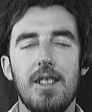

In [ ]:
create_colab_interface(faces_dir)